# Task 4: Bucket FICO scores

Charlie wants to build a **machine learning model** that will predict the probability of default, but while you are discussing the methodology, she mentions that the architecture she is using requires `*categorical data*`. As FICO ratings can take integer values in a large range, they will need to be mapped into `*buckets*`.

**Defination**

> FICO (Fair Isaac Corportation)

> Founders: Bill Fair/ Earl Isaac

A FICO score is a standardized credit score created by the Fair Isaac Corporation (FICO) that quantifies the creditworthiness of a borrower to a value between 300 to 850, based on various factors.

FICO scores are used in 90% of mortgage application decisions in the United States.

**Task**

The risk manager provides you with FICO scores for the borrowers in the bank’s portfolio and wants you to **construct a technique for predicting the PD (probability of default)** for the borrowers using these scores.



- **Aim**
> - Create a rating map that maps the FICO score of the borrowers to a rating where a lower rating signifies a better credit score.
> - You could consider many ways of solving the problem by optimizing different properties of the resulting buckets, such as the mean squared error or log-likelihood

* The process of doing this is known as quantization.

* The simplest way to quantize a signal is to choose the digital amplitude value closest to the original analog amplitude. This example shows the original analog signal (green), the quantized signal (black dots), the signal reconstructed from the quantized signal (yellow) and the difference between the original signal and the reconstructed signal (red). The difference between the original signal and the reconstructed signal is the quantization error and, in this simple quantization scheme, is a deterministic function of the input signal.







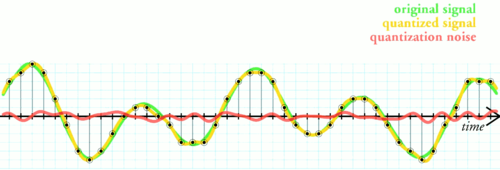

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics  import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/Hongyan-Wang/JP_Morgan_Project/main/Task_3_4_Loan_Data.csv'
df = pd.read_csv(url)
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


# Method 1: Maximum likelihood estimation

- 1. Reads in a CSV file using Pandas. It then creates two lists, x and y, that correspond to the 'observation' and 'rank' columns in the data, respectively.
- 2.  The log-likelihood function is defined to calculate the probability of observing the data given the parameter values.
- 3. The code then initializes a three-dimensional array, dp, that is used to store the calculated log-likelihood values for different sets of observations.
>  a. The first dimension represents the number of iterations performed|
>  b. the second dimension represents the rank of the observation |
>  c. The third dimension represents the log-likelihood and the index of the previous observation.

- 4. The code calculates the log-likelihood for the given data set by using the dp array. It then prints the results and outputs the indices of the observations that were used in the calculation.

## Result:
- 1. log likelyhood: -4217.8245
- 2. results: [850, 753, 752, 732, 696, 649, 611, 580, 552, 520, 300]


In [4]:
x = df['default'].to_list()
y = df['fico_score'].to_list()
n = len(x)
print (len(x), len(y))


10000 10000


In [5]:
default = [0 for i in range(851)]
total = [0 for i in range(851)]

for i in range(n):
    y[i] = int(y[i])
    default[y[i]-300] += x[i]
    total[y[i]-300] += 1

for i in range(0, 551):
    default[i] += default[i-1]
    total[i] += total[i-1]

import numpy as np

def log_likelihood(n, k):
    p = k/n
    if (p==0 or p==1):
        return 0
    return k*np.log(p)+ (n-k)*np.log(1-p)

r = 10
dp = [[[-10**18, 0] for i in range(551)] for j in range(r+1)]

for i in range(r+1):
    for j in range(551):
        if (i==0):
            dp[i][j][0] = 0
        else:
            for k in range(j):
                if (total[j]==total[k]):
                    continue
                if (i==1):
                    dp[i][j][0] = log_likelihood(total[j], default[j])
                else:
                    if (dp[i][j][0] < (dp[i-1][k][0] + log_likelihood(total[j]-total[k], default[j] - default[k]))):
                        dp[i][j][0] = log_likelihood(total[j]-total[k], default[j]-default[k]) + dp[i-1][k][0]
                        dp[i][j][1] = k

print (round(dp[r][550][0], 4))

k = 550
l = []
while r >= 0:
    l.append(k+300)
    k = dp[r][k][1]
    r -= 1

print(l)


-4217.8245
[850, 753, 752, 732, 696, 649, 611, 580, 552, 520, 300]


# Method 2: Using genetic algorithm to optimise


 ## Result:
- 1. log likelyhood: -4243.0575
- 2. results: [850, 765, 729, 715, 696, 637, 608, 552, 541, 510, 300]

In [6]:
df_FICO = df[['fico_score', 'default']]
df_FICO.describe()

,fico_score,default
count,10000.000000,10000.000000
mean,637.557700,0.185100
std,60.657906,0.388398
min,408.000000,0.000000
25%,597.000000,0.000000
50%,638.000000,0.000000
75%,679.000000,0.000000
max,850.000000,1.000000


In [9]:
pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15080 sha256=a6562cd41bfcf54370168b6bb3f246747458a3865b92e3783f3afabcbc2d80de
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [14]:
from geneticalgorithm import geneticalgorithm as ga

In [19]:
def f(d):
  LL = 0
  for i in range(len(d)):
    if i == 0:
      l, u = 400, d[i+1]
    elif i == len(d) - 1:
      l, u = d[i], 850
    else:
      l, u = d[i], d[i+1]
    k = df_FICO.query(f'{l} < fico_score <= {u}')['default'].sum()
    n = df_FICO.query(f'{l} < fico_score <= {u}')['default'].shape[0]
    p = k / n if n != 0 else 0
    p = max(0.01, p)
    LL += k * np.log(p) + (n - k) * np.log(1 - p)
  return -1 * LL

 The best solution found:
 [541. 510. 552. 608. 637. 696. 715. 729. 765.]

 Objective function:
 4243.057532745642


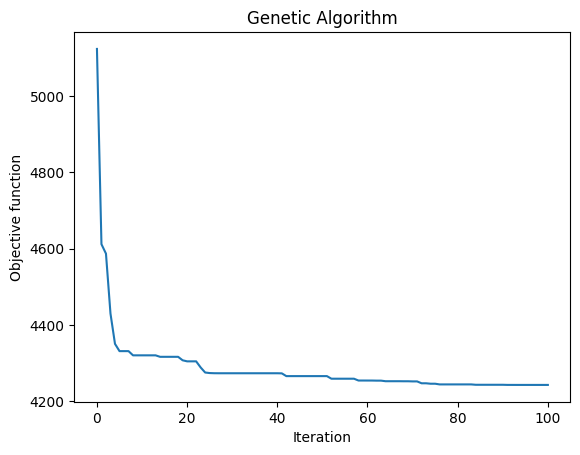

In [20]:
n = 9
varbound = np.array([[400, 850]] * n)
model = ga(function=f, dimension=n, variable_type='int', variable_boundaries=varbound,
           algorithm_parameters = {'max_num_iteration':100, 'population_size': 100,
                                   'mutation_probability': 0.1,'elit_ratio': 0.01,
                                   'crossover_probability': 0.5,'parents_portion': 0.3,
                                   'crossover_type': 'uniform','max_iteration_without_improv': None},
           convergence_curve=True, progress_bar=True)
model.run()